In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    

TensorFlow Version: 2.0.0
Default GPU Device: /device:GPU:0


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns

from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import pickle
import numpy as np

# graph visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))
        
def compare_mlp_cnn_tr(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

Traffic Preprocess


In [4]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=4, n_col=8):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=32)
    n = 0
    for i in rand_sample:
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i][0])
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())
        n = n+1

In [5]:
file = open("./data/traffic/data0.pickle", "rb")
data = pickle.load(file) 

In [6]:
X_train_tr = data['x_train']
X_test_tr = data['x_test']
y_train_tr = data['y_train']
y_test_tr = data['y_test']

In [7]:
np.transpose(X_train_tr[500], (2, 1, 0)).shape

(32, 32, 3)

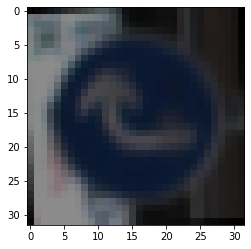

In [8]:
# np.transpose(img, (1, 2, 0))

plt.imshow(np.transpose(X_train_tr[500], (2, 1, 0)), interpolation='nearest')

# plt.imshow(X_train_tr[500][2], interpolation='nearest')


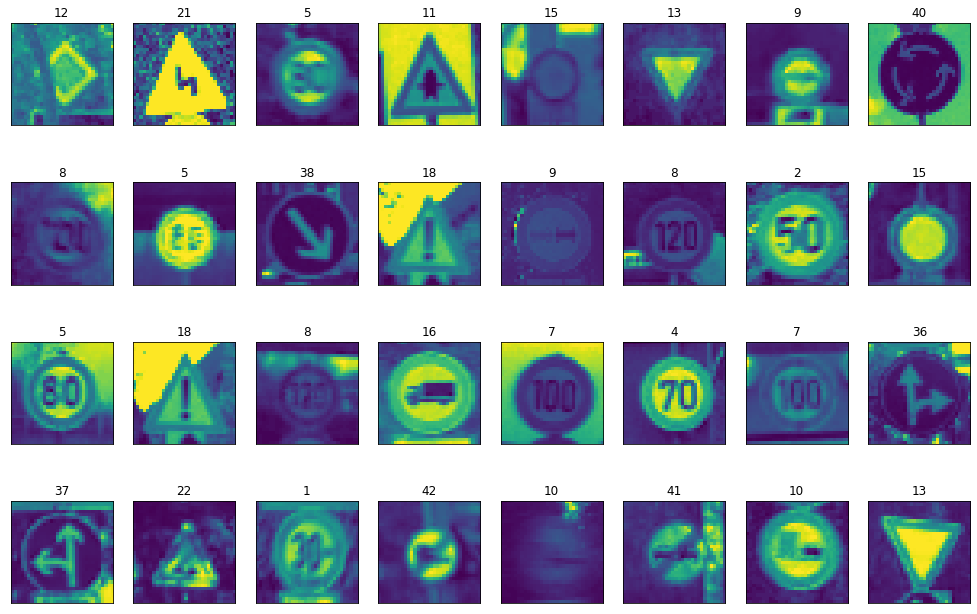

In [9]:
plot_gallery(X_test_tr, y_test_tr,32,32)

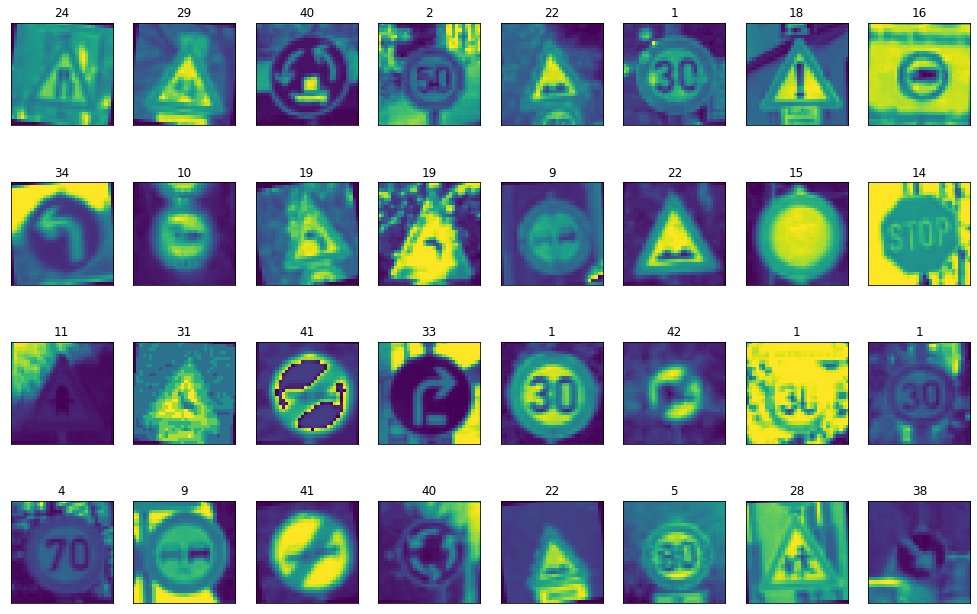

In [10]:
plot_gallery(X_train_tr, y_train_tr,32,32)

In [11]:
print(X_train_tr.shape)
print(y_train_tr.shape)

(86989, 3, 32, 32)
(86989,)


In [12]:
X_train_tr[0].shape

(3, 32, 32)

In [13]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=8, # used, Int. Degree range for random rotations.
    width_shift_range=0.2, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.2, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    data_format='channels_first',
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train_tr)

X_train_tr.shape
# print(tmps.shape)
# print(tmps[0])


#X_train_tr = X_train_tr/255 - .5
#X_test_tr = X_test_tr/255 - .5

(86989, 3, 32, 32)

In [14]:
tmps = datagen.flow(X_train_tr, y_train_tr, batch_size=1)
count=0
xdata=[]
ydata=[]
for tmp in tmps:
    #tt=np.transpose(tmp[0].squeeze(), (1, 2, 0))
    tt=tmp[0].squeeze()
    tt=tt.astype('uint8')
    xdata.append(tt)
    ydata.append(tmp[1][0])
    #print(tt.shape)
    #plt.imshow(out.astype('uint8'))
    #print(tt)
    #print(tmp[1][0])
    #imshow(tt,cmap='bone')
    
    #plt.title(classes[np.argmax(tmp[1])])
    count+=1
    if count==5000:
        break
        
xdata=np.asarray(xdata, dtype=np.float32)
ydata=np.array(ydata)
# print("xdata shape: ",xdata.shape)
# print("ydata shape: ",ydata.shape)
# ydata[0]

print("X_train_tr shape: ",X_train_tr.shape)
print("y_train_tr shape: ",y_train_tr.shape)

X_train_tr = np.append(X_train_tr, xdata, axis=0)
y_train_tr = np.append(y_train_tr, ydata)

print("\nOnce expanded data is added")
print("X_train_tr shape: ",X_train_tr.shape)
print("y_train_tr shape: ",y_train_tr.shape)

X_train_tr shape:  (86989, 3, 32, 32)
y_train_tr shape:  (86989,)

Once expanded data is added
X_train_tr shape:  (91989, 3, 32, 32)
y_train_tr shape:  (91989,)


Arch 1 param 1

In [15]:
%%time
'''
INIT ARCHITECTURE
'''
img_sz = 32 # width and height of img

y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters,
                     #input_shape = (3,img_sz,img_sz),
                     kernel_size=(3,3), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(43, activation='softmax') )

cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# cnn1.fit(X_train_tr, y_train_ohe_tr, 
#          batch_size=32, 
#          epochs=15, 
#          shuffle=True, 
#          verbose=1,
#          validation_data=(X_test_tr,y_test_ohe_tr),
#          callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
#         )

# cnn1.fit_generator(datagen.flow(X_train_tr, y_train_ohe_tr, batch_size=64), 
#                    steps_per_epoch=int(len(X_train_tr)/64), # how many generators to go through per epoch
#                    epochs=20, verbose=1,
#                    validation_data=(X_test_tr,y_test_ohe_tr),
#                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#                   )


# cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                    steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
#                    epochs=5, verbose=1,
#                    validation_data=(X_test,y_test_ohe)
#                   )


Wall time: 1.17 s


In [16]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn1.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 91989 samples, validate on 12630 samples
Epoch 1/15
91989/91989 [==============================] - 24s 266us/step - loss: 0.0156 - accuracy: 0.5070 - val_loss: 0.0097 - val_accuracy: 0.7369
Epoch 2/15
91989/91989 [==============================] - 23s 252us/step - loss: 0.0058 - accuracy: 0.8444 - val_loss: 0.0086 - val_accuracy: 0.7824
Epoch 3/15
91989/91989 [==============================] - 23s 253us/step - loss: 0.0050 - accuracy: 0.8738 - val_loss: 0.0073 - val_accuracy: 0.8249
Epoch 4/15
91989/91989 [==============================] - 24s 258us/step - loss: 0.0047 - accuracy: 0.8825 - val_loss: 0.0074 - val_accuracy: 0.8238
Epoch 5/15
91989/91989 [==============================] - 24s 257us/step - loss: 0.0045 - accuracy: 0.8879 - val_loss: 0.0071 - val_accuracy: 0.8335
Epoch 6/15
91989/91989 [==============================] - 23s 255us/step - loss: 0.0047 - accuracy: 0.8832 - val_loss: 0.0090 - val_accuracy: 0.7865
Epoch 7/15
91989/91989 [==============================] 

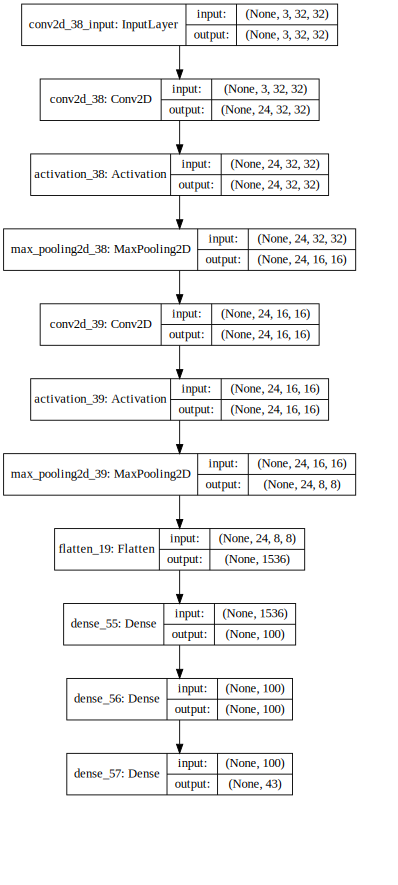

In [106]:
SVG(model_to_dot(cnn1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

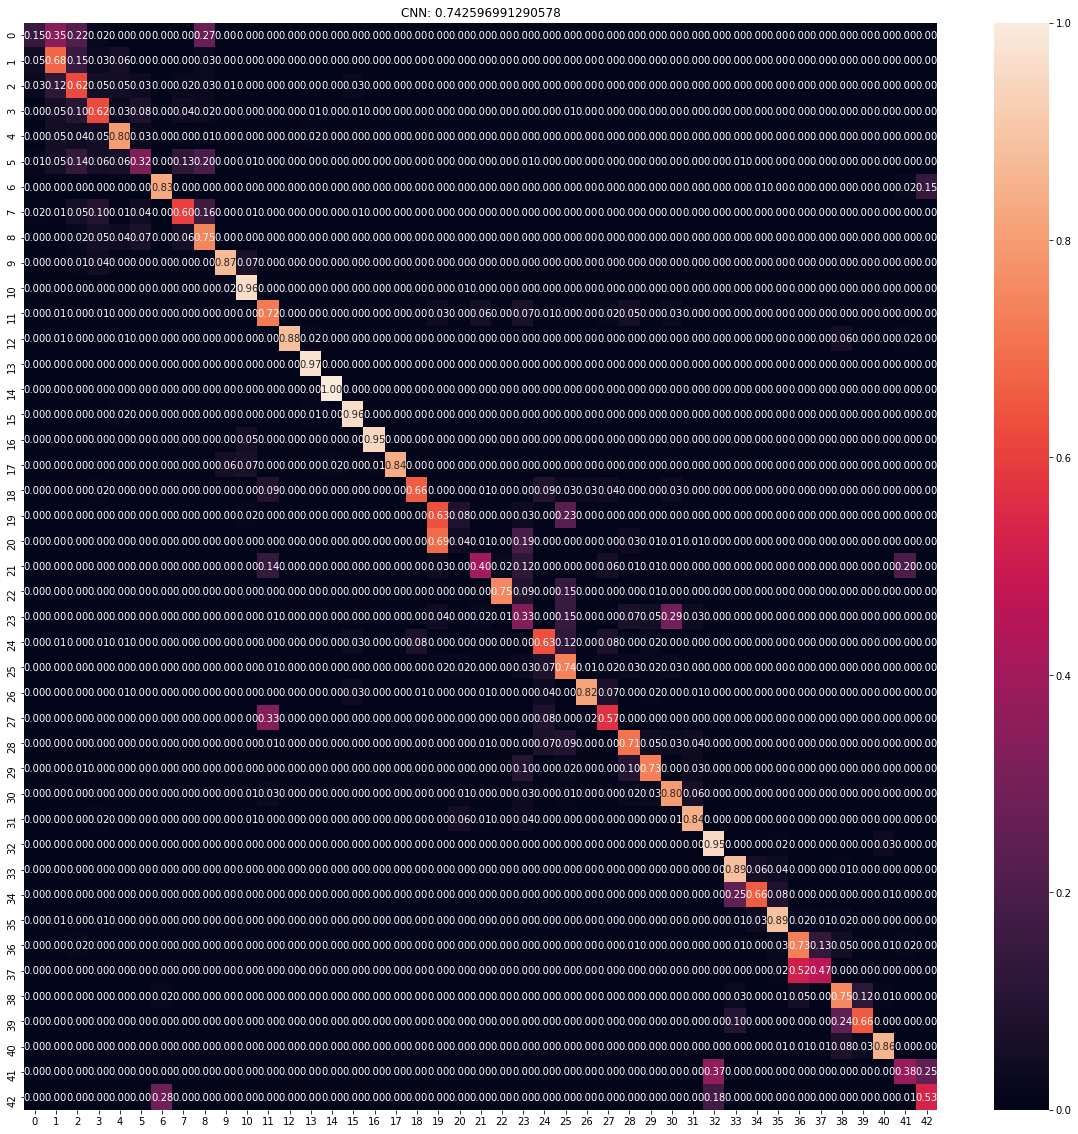

In [111]:
compare_mlp_cnn_tr(cnn1,None,X_test_tr,y_test_tr)

In [80]:
data["labels"]
for x in range(len(data["labels"])):
    print("{}: {}".format(x,data["labels"][x]))

0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing for vehicles over 3.5 metric tons
11: Right-of-way at the next intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles over 3.5 metric tons prohibited
17: No entry
18: General caution
19: Dangerous curve to the left
20: Dangerous curve to the right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End of all speed and passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout mandatory
41: End of no passing
42: End of no passing by vehic

In [35]:
%%time
'''
CHANGES:
 - DOUBLED SIZE OF SECOND FILTER LAYER
 - INCREASED SIZE OF KERNEL TO (4,4)
 - CHANGED THE ACTIVATION FUNCTION IN THE 2 DENSE LAYERS TO LINEAR
'''

img_sz = 32 # width and height of img

y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

cnn2 = Sequential()
num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters,
                     
                     kernel_size=(4,4), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn2.add( Activation('relu'))
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    
cnn2.add( Flatten() )
cnn2.add( Dense(100, activation='linear') )
cnn2.add( Dense(100, activation='linear') )
cnn2.add( Dense(43, activation='softmax') )

cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])


# # DATA FORMAT -> (channels, x-dim, y-dim)
# cnn2.fit(X_train_tr, y_train_ohe_tr, 
#          batch_size=32, 
#          epochs=15, 
#          shuffle=True, 
#          verbose=1,
#          validation_data=(X_test_tr,y_test_ohe_tr),
#          callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
#         )

cnn2.fit_generator(datagen.flow(X_train_tr, y_train_ohe_tr, batch_size=64), 
                   steps_per_epoch=int(len(X_train_tr)/64), # how many generators to go through per epoch
                   epochs=7, verbose=1,
                   validation_data=(X_test_tr,y_test_ohe_tr)
                  )

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_19/MaxPool' (op: 'MaxPool') with input shapes: [?,24,32,1].

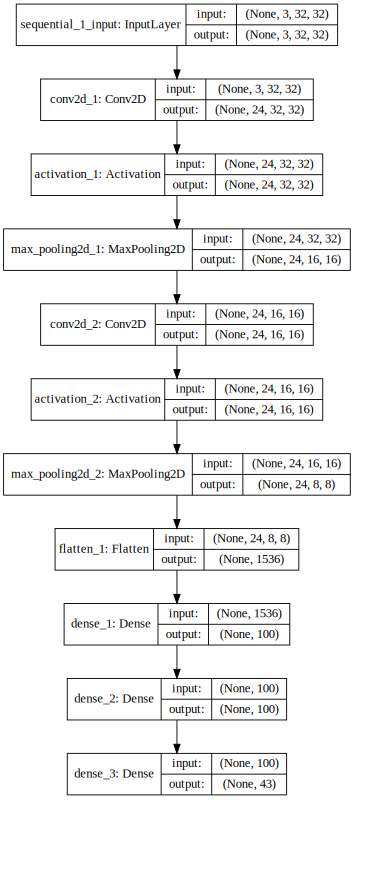

In [22]:
SVG(model_to_dot(cnn1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [24]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn2.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 86989 samples, validate on 12630 samples
Epoch 1/15
86989/86989 [==============================] - 26s 298us/step - loss: 0.0047 - accuracy: 0.8511 - val_loss: 0.0036 - val_accuracy: 0.9029
Epoch 2/15
86989/86989 [==============================] - 26s 298us/step - loss: 0.0017 - accuracy: 0.9565 - val_loss: 0.0034 - val_accuracy: 0.9137
Epoch 3/15
86989/86989 [==============================] - 26s 297us/step - loss: 0.0015 - accuracy: 0.9619 - val_loss: 0.0039 - val_accuracy: 0.9071
Epoch 4/15
86989/86989 [==============================] - 26s 298us/step - loss: 0.0015 - accuracy: 0.9641 - val_loss: 0.0035 - val_accuracy: 0.9182
Wall time: 1min 44s


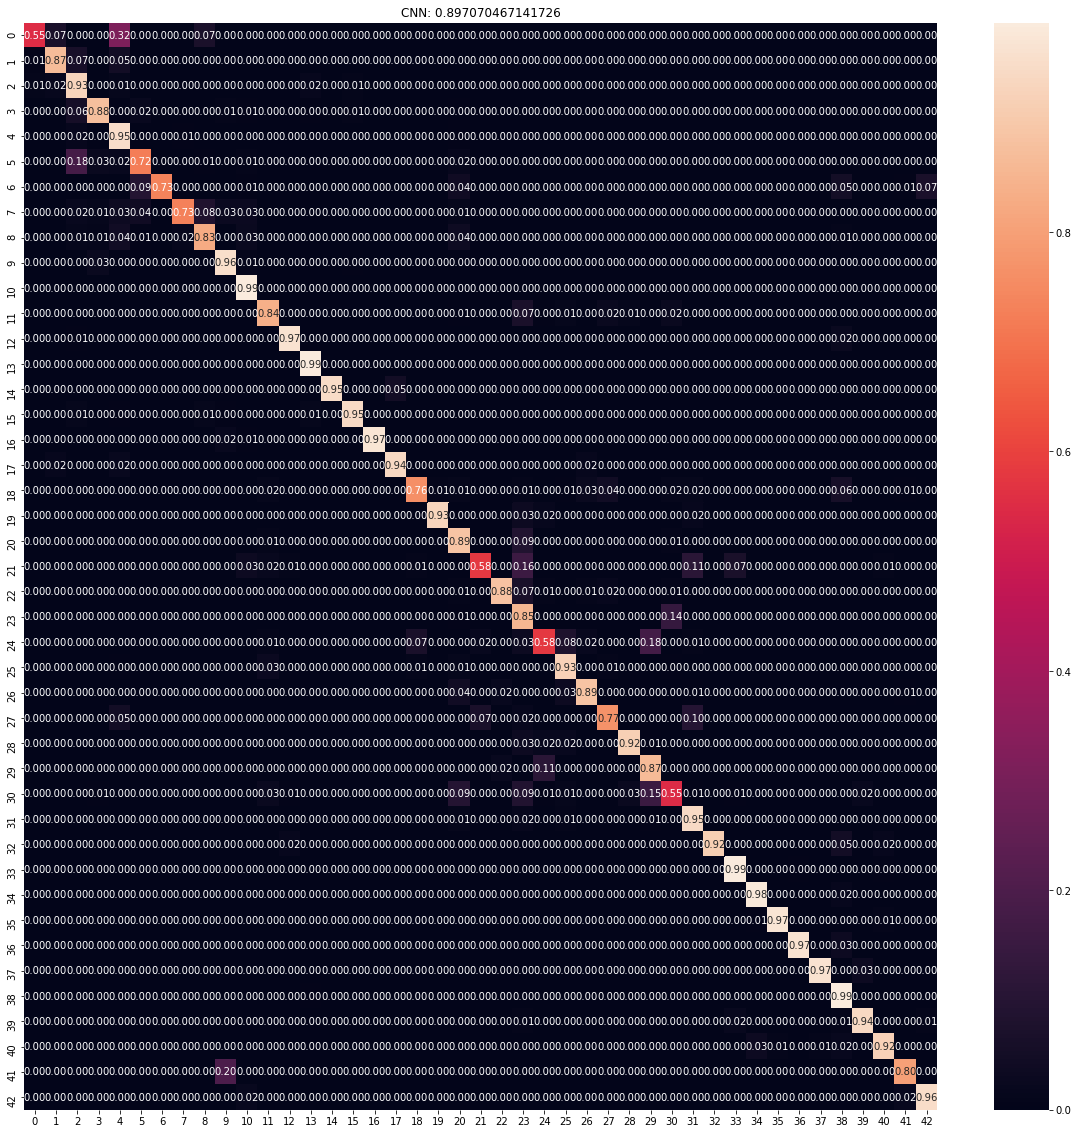

In [25]:
compare_mlp_cnn_tr(cnn2,None,X_test_tr,y_test_tr)